<a href="https://colab.research.google.com/github/faaddhhllii/llyods_bank_prediction_churn/blob/main/notebooks/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelling

In [ ]:
# split x_train and y_train data
from sklearn.model_selection import train_test_split

x = df_merged.drop("ChurnStatus", axis=1)
y = df_merged["ChurnStatus"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# train model
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# randomforest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x_train, y_train)

# xgboost
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(x_train, y_train)

# determine the matrix from scratch
import numpy as np

def metrics_scratch (y_true, y_pred):
  TP = np.sum((y_true == 1) & (y_pred == 1))
  TN = np.sum((y_true == 0) & (y_pred == 0))
  FP = np.sum((y_true == 0) & (y_pred == 1))
  FN = np.sum((y_true == 1) & (y_pred == 0))

  accuracy = (TP + TN) / (TP + TN + FP + FN)
  precision = TP / (TP + FP) if (TP + FP) != 0 else 0
  recall = TP / (TP + FN) if (TP + FN) != 0 else 0
  f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0


  return {
      "TP": TP, "TN": TN, "FP": FP, "FN": FN,
      "Accuracy" : accuracy,
      "Precision" : precision,
      "Recall" : recall,
      "F1 Score" : f1_score
  }

# evaluation
rf_result = metrics_scratch(y_test.to_numpy(), rf_model.predict(x_test))
xgb_result = metrics_scratch(y_test.to_numpy(), xgb_model.predict(x_test))

# print tabel
df_hasil = pd.DataFrame([rf_result, xgb_result], index=["Random Forest", "XGBoost"])
print(df_hasil)

                TP   TN  FP  FN  Accuracy  Precision    Recall  F1 Score
Random Forest  203  826   0  12  0.988473   1.000000  0.944186  0.971292
XGBoost        209  825   1   6  0.993276   0.995238  0.972093  0.983529


If you look at the evaluation results, both Random Forest and XGBoost have very high performance. Random Forest on the love test data has an accuracy of around 98.8% with an F1-score of 0.97, while XGBoost is slightly superior with an accuracy of 99.3% and an F1-score of 0.98. In terms of precision, both are almost perfect, so the model rarely misrepresents people churning when they actually don't. The difference is in recall, where XGBoost is better (0.97 compared to 0.94 in Random Forest). This is important, because for churn cases we really need a model that can capture as many customers as possible who really want to leave.

In [ ]:
import pandas as pd

# Calculate metrics for train & test (RandomForest)
rf_train_metrics = metrics_scratch(y_train.to_numpy(), rf_model.predict(x_train))
rf_test_metrics  = metrics_scratch(y_test.to_numpy(),  rf_model.predict(x_test))

# Calculate metrics for train & test (XGBoost)
xgb_train_metrics = metrics_scratch(y_train.to_numpy(), xgb_model.predict(x_train))
xgb_test_metrics  = metrics_scratch(y_test.to_numpy(),  xgb_model.predict(x_test))

# Merge to DataFrame
df_overfit = pd.DataFrame({
    "RF_Train": rf_train_metrics,
    "RF_Test": rf_test_metrics,
    "XGB_Train": xgb_train_metrics,
    "XGB_Test": xgb_test_metrics
})

print(df_overfit)


           RF_Train     RF_Test  XGB_Train    XGB_Test
TP            857.0  203.000000      857.0  209.000000
TN           3306.0  826.000000     3306.0  825.000000
FP              0.0    0.000000        0.0    1.000000
FN              0.0   12.000000        0.0    6.000000
Accuracy        1.0    0.988473        1.0    0.993276
Precision       1.0    1.000000        1.0    0.995238
Recall          1.0    0.944186        1.0    0.972093
F1 Score        1.0    0.971292        1.0    0.983529


If we compare the performance on train and test data, the results are very stable, so the risk of overfitting is small. But a very high metric can also be a sign that the dataset is relatively easy to predict or that there is data imbalance. Overall, you could say that XGBoost is better than Random Forest, especially because it is better in terms of recall and F1-score. So if the goal is not to miss customers who want to churn, XGBoost is more suitable to use.

ROC AUC Random Forest: 0.9968382228729096
ROC AUC XGBoost: 0.9866152373444451


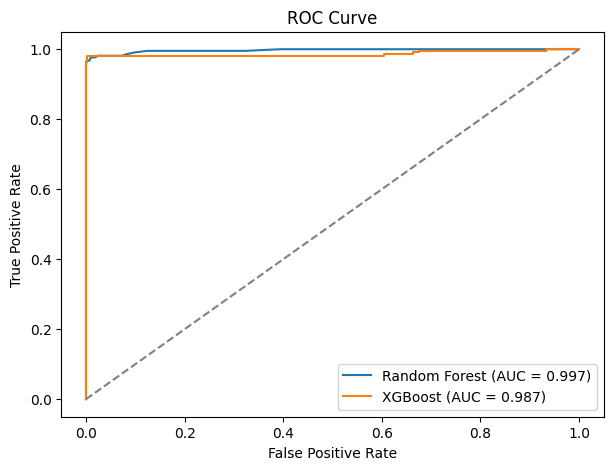

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# ROC AUC Random Forest
rf_probs = rf_model.predict_proba(x_test)[:, 1]     # take positive class probability (1)
rf_auc = roc_auc_score(y_test, rf_probs)

# ROC AUC XGBoost
xgb_probs = xgb_model.predict_proba(x_test)[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_probs)

print("ROC AUC Random Forest:", rf_auc)
print("ROC AUC XGBoost:", xgb_auc)

# Plot ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)

plt.figure(figsize=(7,5))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {rf_auc:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {xgb_auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray") # garis random guess
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


Based on the evaluation results, both Random Forest and XGBoost show very high performance with ROC AUC values close to 1 (0.997 for Random Forest and 0.987 for XGBoost). This indicates that both models are able to differentiate between churn and non-churn classes very well. When compared, Random Forest is slightly superior, although the performance difference is relatively small.

Interestingly, even though the dataset used has class imbalance, both models remain robust and are not too affected by this. This is also supported by other previously calculated metrics (precision, recall, and F1-score), which show the consistency of the results. In other words, both Random Forest and XGBoost are equally reliable for this case, it's just that Random Forest seems more optimal in modeling the available churn data.

In [ ]:
from sklearn.model_selection import GridSearchCV

# definisikan parameter grid
rf_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    scoring="roc_auc",   # pakai ROC AUC biar sesuai dengan evaluasi kamu
    cv=5,                # 5-fold cross validation
    n_jobs=-1,
    verbose=2
)

rf_grid.fit(x_train, y_train)

print("Best Parameters RF:", rf_grid.best_params_)
print("Best ROC AUC RF:", rf_grid.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters RF: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best ROC AUC RF: 0.9965304077486025


In [ ]:
xgb_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    param_grid=xgb_param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=2
)

xgb_grid.fit(x_train, y_train)

print("Best Parameters XGB:", xgb_grid.best_params_)
print("Best ROC AUC XGB:", xgb_grid.best_score_)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:26:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters XGB: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300, 'subsample': 1.0}
Best ROC AUC XGB: 0.9927757987226247


In [ ]:
import pandas as pd
from sklearn.metrics import roc_auc_score

# --- Default Models ---
rf_default = RandomForestClassifier(random_state=42)
rf_default.fit(x_train, y_train)
xgb_default = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_default.fit(x_train, y_train)

# --- Tuned Models (dari GridSearch) ---
rf_tuned = rf_grid.best_estimator_
xgb_tuned = xgb_grid.best_estimator_

# --- Evaluasi di test set ---
models = {
    "Random Forest (Default)": rf_default,
    "Random Forest (Tuned)": rf_tuned,
    "XGBoost (Default)": xgb_default,
    "XGBoost (Tuned)": xgb_tuned
}

results = []
for name, model in models.items():
    y_prob = model.predict_proba(x_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    results.append({"Model": name, "ROC AUC (Test)": auc})

df_results = pd.DataFrame(results)
print(df_results)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:26:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                     Model  ROC AUC (Test)
0  Random Forest (Default)        0.996838
1    Random Forest (Tuned)        0.998181
2        XGBoost (Default)        0.986615
3          XGBoost (Tuned)        0.990715


From the test results, all models—both Random Forest and XGBoost, with default and GridSearchCV tuning results—show very high performance with ROC AUC values above 0.98. This means the model is able to differentiate very well between churned and non-churn customers.

When compared, Random Forest is slightly superior. The tuned version of Random Forest produces the highest ROC AUC, namely 0.9981, higher than the tuned XGBoost (0.9907). However, the difference in this value is relatively small, meaning that both algorithms are equally reliable.

Insight to take away: model tuning does provide a slight performance increase (especially in Random Forest), but overall, both Random Forest and XGBoost are very good at handling this case.

/tmp/ipython-input-1080572131.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=rf_importances.head(10), palette="viridis")


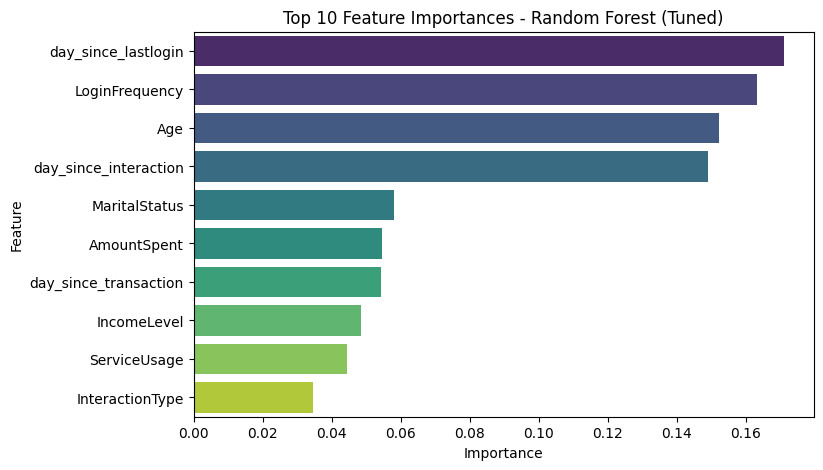

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importance Random Forest
rf_importances = pd.DataFrame({
    "Feature": x_train.columns,
    "Importance": rf_tuned.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=rf_importances.head(10), palette="viridis")
plt.title("Top 10 Feature Importances - Random Forest (Tuned)")
plt.show()


Random Forest → focuses more on customer activity & interaction behavior on the platform.

/tmp/ipython-input-2834966290.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=xgb_importances.head(10), palette="magma")


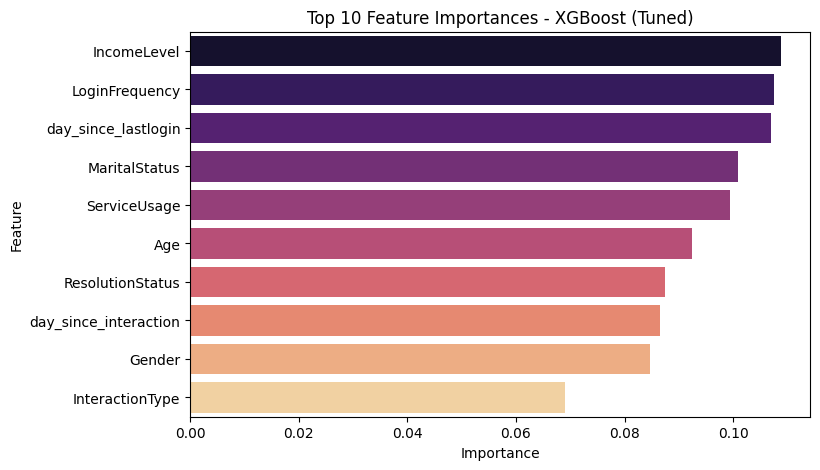

In [ ]:
# Feature importance XGBoost
xgb_importances = pd.DataFrame({
    "Feature": x_train.columns,
    "Importance": xgb_tuned.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=xgb_importances.head(10), palette="magma")
plt.title("Top 10 Feature Importances - XGBoost (Tuned)")
plt.show()



XGBoost → focuses more on economic & demographic factors, with login behavior as support.